# Chapter 1 

# Optimizing Generative AI Workloads with Embedded ARM Processors

## Introduction

Welcome to the **Optimizing Generative AI Workloads with ARM Vector Instructions** lab! In this hands-on session, you will explore how ARM's advanced vector processing capabilities can significantly accelerate computationally intensive tasks commonly found in artificial intelligence (AI) applications. By the end of this lab, you will gain a deep understanding of how low-level optimizations can enhance performance and how to leverage these optimizations within high-level AI frameworks like PyTorch.

**Requirements**: for this lab you will need an ARMv8 64-bit system with an install of a linux based operating system such as a Raspberry Pi 4 or 5. This lab has been tested with the Pi 5. 

### **Why ARM Vector Instructions?**

ARM processors are ubiquitous in modern computing, powering everything from smartphones to edge devices and increasingly, servers and supercomputers. Their architecture is designed for energy efficiency and performance, making them ideal for deploying AI models in diverse environments. One of the key features that enable ARM processors to excel in AI workloads is their support for **vector instructions**, such as NEON and i8mm, which allow for parallel processing of multiple data points in a single instruction cycle.

### **Lab Objectives**

The objectives of this lab are as follows: 

1. **Matrix Multiplication Optimization**:
   - Analyze three C-based matrix multiplication implementations (`naive`, `fp32_neon`, and `int8_neon`) to understand their performance differences.
   - Utilize ARMv8's NEON vector processing capability to accelerate matrix multiplications. The fundamental operation of AI workloads. 

2. **Benchmark PyTorch Operations**:
   - Measure the performance of PyTorch's matrix multiplication operations in different precisions. 
   - Examine the generated assembly code to identify how pytorch accelerates matrix multiplications

3. **Run Inference on a Language Model**:
   - Load and run inference on the state-of-the-art small language model, Llama3.2-1B.
   - Explore its computational graph to understand the underlying operations.

4. **Eager vs. Graph Execution**:
   - Compare PyTorch's Eager mode and Graph Execution.
   - Use `torch.compile` to minimize overhead and improve runtime performance.

5. **Apply Integer Quantization**:
   - Learn how integer quantization can reduce model size and accelerate inference.
   - Implement and evaluate quantization on matrix multiplication operations.
   - Apply Integer Quantization to Lamma3.2-1B and record it's latency speed ups and memory reductions. 



### **What You Will Learn**

- **Low-Level Optimizations**: Understand how ARM's NEON SIMD instructions can accelerate matrix computations.
- **Performance Benchmarking**: Develop skills to benchmark operations effectively and analyze performance trade-offs.
- **Framework Integration**: Explore how low-level optimizations can complement high-level frameworks like PyTorch.
- **Quantization Techniques**: Learn to implement quantization for efficient AI workloads on resource-constrained devices.

### **Prerequisites**

To follow this lab, you should have a basic understanding of:

- **C Programming**: Familiarity with C syntax and basic memory management.
- **Python Programming**: Experience writing and running Python scripts.
- **Matrix Operations**: A general understanding of matrix multiplication and its computational requirements.

### **Getting Started**

The lab begins with exploring matrix multiplication kernels, implemented in the following C files:

1. **Naive Kernel (`src/c/kernels/naive.c`)**:
   - A straightforward implementation to establish a baseline.

2. **FP32 NEON Kernel (`src/c/kernels/fp32_neon.c`)**:
   - Optimized for single-precision floating-point operations using ARM NEON SIMD instructions.

3. **INT8 NEON Kernel (`src/c/kernels/int8_neon.c`)**:
   - Optimized for 8-bit integer operations with NEON SIMD.

---

Let’s dive in and start optimizing generative AI workloads on embedded ARM devices!

### **Mathematics of Matrix Multiplication and Its Importance in Generative AI Models**

#### **Basic Mathematics of Matrix Multiplication**

Matrix multiplication is a fundamental operation in linear algebra with wide-ranging applications in computer science, engineering, and especially in machine learning and AI. Given two matrices **A** and **B**, the product **C = A × B** is defined only if the number of columns in **A** matches the number of rows in **B**.

Mathematically, if **A** is an *m × n* matrix and **B** is an *n × p* matrix, then their product **C** will be an *m × p* matrix. The element at position *(i, j)* in matrix **C** is computed as:

$$C_{i,j} = \sum_{k=1}^{n} A_{i,k} \times B_{k,j}$$

**Example:**

Consider matrices **A** (2×3) and **B** (3×2):

$$
\mathbf{A} = \begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23}
\end{bmatrix},
\quad
\mathbf{B} = \begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22} \\
b_{31} & b_{32}
\end{bmatrix}
$$

Their product **C = A × B** (2×2) is:

$$
\mathbf{C} = \begin{bmatrix}
c_{11} & c_{12} \\
c_{21} & c_{22}
\end{bmatrix}
$$

where:

$$
\begin{align*}
c_{11} &= a_{11}b_{11} + a_{12}b_{21} + a_{13}b_{31} \\
c_{12} &= a_{11}b_{12} + a_{12}b_{22} + a_{13}b_{32} \\
c_{21} &= a_{21}b_{11} + a_{22}b_{21} + a_{23}b_{31} \\
c_{22} &= a_{21}b_{12} + a_{22}b_{22} + a_{23}b_{32}
\end{align*}
$$

#### **Computational Complexity**

The naive matrix multiplication algorithm has a time complexity of **O(n³)**, which becomes computationally expensive for large matrices. Optimizations, such as those leveraging vector instructions, aim to reduce the constant factors and improve cache utilization, thereby enhancing performance without altering the theoretical complexity.


<br><br><br>

### **Implementation of Naive Matrix Multiplication Kernel**

The naive implementation of matrix multiplication directly follows the mathematical definition. It uses three nested loops to compute the dot product of rows from matrix **A** and columns from matrix **B** for every element in the resulting matrix **C**. This is the most straightforward and intuitive approach but is computationally expensive due to its **O(n³)** time complexity.

#### **Code Explanation**

1. **Inputs**:
   - **A**, **B**: Flattened 2D matrices (stored as 1D arrays) to be multiplied.
   - **C**: Flattened 2D matrix (1D array) to store the result.
   - **N**: Size of the square matrices (number of rows/columns).

2. **Procedure**:
   - The outer two loops iterate over the rows and columns of the resulting matrix **C**.
   - The innermost loop calculates the dot product for each element **C[i, j]** by summing the product of corresponding elements from row **i** of **A** and column **j** of **B**.

3. **Performance**:
   - This naive implementation is simple but does not leverage advanced optimization techniques, such as blocking, vectorization, or parallelism.

#### **Naive Kernel Implementation**



In [29]:
%%writefile src/c/kernels/naive.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrix_multiply_naive(float* A, float* B, float* C, int N) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            C[i * N + j] = 0;
            for (int k = 0; k < N; k++) {
                C[i * N + j] += A[i * N + k] * B[k * N + j];
            }
        }
    }
}

Overwriting src/c/kernels/naive.c


### **Introduction to NEON SIMD Instructions**

NEON (ARM Advanced SIMD) is a set of SIMD (Single Instruction, Multiple Data) instructions designed to accelerate data-parallel operations on ARM processors. By leveraging NEON, computations on matrices, such as matrix multiplication, can be vectorized to process multiple data points simultaneously, thereby reducing execution time.

#### **FP32 Matrix Multiplication Using NEON Instructions**

1. **Vectorized Processing**:
   - In this implementation, the function processes four `float32` elements at a time, utilizing NEON's 128-bit registers (`float32x4_t`).
   - The accumulation is performed using fused multiply-add operations, which minimize intermediate memory accesses.

2. **Key NEON Instructions Used**:
   - **`vld1q_f32`**: Loads four 32-bit floating-point elements into a vector register.
   - **`vmlaq_f32`**: Performs a fused multiply-add operation on vectors.

3. **Reduction Step**:
   - The vector accumulator is reduced into a scalar using:
     - **`vadd_f32`**: Adds low and high parts of the vector.
     - **`vpadd_f32`**: Horizontally adds remaining elements for a final scalar result.

4. **Description**:
   - The function performs matrix multiplication for `float32` matrices by iterating over the rows and columns of the input matrices, processing four elements at a time in the inner loop. This approach uses NEON to accelerate the computation by leveraging SIMD parallelism.






In [30]:
%%writefile src/c/kernels/fp32_neon.c

#include <arm_neon.h>
#include <stdio.h>

void matmul_fp32_neon(float* A, float* B, float* C, int N) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            float32x4_t acc = vdupq_n_f32(0.0f); // Accumulator
            for (int k = 0; k < N; k += 4) { // Process 4 elements at a time
                float32x4_t a_vec = vld1q_f32(&A[i * N + k]); // Load row of A
                float32x4_t b_vec = vld1q_f32(&B[k * N + j]); // Load column of B
                acc = vmlaq_f32(acc, a_vec, b_vec); // Multiply-accumulate
            }
            // Reduce acc to a single value and store in C
            float32x2_t sum1 = vadd_f32(vget_low_f32(acc), vget_high_f32(acc));
            float sum = vget_lane_f32(vpadd_f32(sum1, sum1), 0);
            C[i * N + j] = sum;
        }
    }
}

Overwriting src/c/kernels/fp32_neon.c


### **Introduction to Quantized (INT8) Matrix Multiplication Using NEON SIMD**

Quantized matrix multiplication uses low-precision (8-bit integer) representations to reduce memory bandwidth, power consumption, and computational complexity. ARM processors with NEON i8mm (integer 8-bit matrix multiplication) instructions provide significant acceleration by increasing the level of vectorization and benefiting from the efficiency of integer arithmetic.

#### **INT8 Matrix Multiplication Using NEON Instructions**

1. **Increased Levels of Vectorization**:
   - The implementation processes eight `int8_t` elements at a time, leveraging the higher data packing density of 8-bit integers compared to `float32` (four elements at a time). This doubles the level of parallelism compared to the FP32 implementation.

2. **Key NEON Instructions Used**:
   - **`vld1_s8`**: Loads eight signed 8-bit integers into a vector register.
   - **`vmlal_s8`**: Multiplies two vectors of signed 8-bit integers and accumulates the results into 16-bit integers.

3. **Reduction Step**:
   - **`vaddvq_s16`**: Horizontally sums the elements of a 16-bit integer vector to produce a scalar result.

4. **Advantages Over FP32 Implementation**:
   - **Higher Vectorization**: Processes eight elements at a time versus four in the FP32 version.
   - **Integer Arithmetic**: Integer operations are inherently faster than floating-point operations on most hardware due to simpler hardware requirements.
   - **Lower Memory Usage**: `int8_t` data consumes four times less memory than `float32`, leading to reduced cache pressure and better memory bandwidth utilization.
   - **Energy Efficiency**: Integer computations typically consume less power, making this approach ideal for energy-constrained environments.

5. **Description**:
   - The function performs matrix multiplication for quantized `int8` matrices by iterating over the rows and columns of the input matrices. In the inner loop, eight elements are processed simultaneously using NEON SIMD instructions. The 16-bit intermediate results are accumulated, and the final reduction produces a 32-bit scalar result for each element of the output matrix.




In [31]:
%%writefile src/c/kernels/int8_neon.c

#include <arm_neon.h>
#include <stdio.h>

void matmul_int8_neon(int8_t* A, int8_t* B, int32_t* C, int N) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            int16x8_t acc = vdupq_n_s16(0); // Initialize 16-bit accumulator

            for (int k = 0; k < N; k += 8) { // Process 8 elements at a time
                // Load 8 int8 elements from row of A and column of B
                int8x8_t a_vec = vld1_s8(&A[i * N + k]);
                int8x8_t b_vec = vld1_s8(&B[k * N + j]);

                // Perform element-wise multiplication and accumulate
                acc = vmlal_s8(acc, a_vec, b_vec);
            }

            // Reduce the 16-bit accumulator into a 32-bit scalar
            int32_t sum = vaddvq_s16(acc); // Horizontally sum all elements in the vector
            C[i * N + j] = sum; // Store the result in C
        }
    }
}

Overwriting src/c/kernels/int8_neon.c


### **Compiling Each Kernel to Inspect Assembly Using GCC**

If you're on a system with native ARM support or an ARM-compatible GCC installation, you can use `gcc` directly to compile the kernels into assembly code. 

#### **Steps to Compile Each Kernel**

For each kernel, use the following command:

In [32]:
!gcc -O0 -S -march=armv8-a+simd src/c/kernels/naive.c -o bin/naive.s
!gcc -O3 -S -march=armv8-a+simd src/c/kernels/fp32_neon.c -o bin/fp32_neon.s
!gcc -O3 -S -march=armv8-a+simd src/c/kernels/int8_neon.c -o bin/int8_neon.s

---
### 1. **Naive Implementation**
   - Uses scalar instructions exclusively, meaning each operation processes a single pair of data values at a time.
   - Relies on the following types of ARM assembly instructions:
     - **`ldr` (Load Register):** Loads a value from memory into a register.
     - **`str` (Store Register):** Stores a value from a register into memory.
     - **`mul` (Multiply):** Multiplies two values in registers.
     - **`add` (Add):** Adds two values in registers.
   - Does not utilize SIMD (Single Instruction Multiple Data) capabilities, which can process multiple data values simultaneously in a single instruction.
   - Experiences significant overhead in memory operations due to the frequent use of `ldr` and `str` instructions for each operation, as no batching or parallelism is applied.

#### Observations:
   - Computational units are underutilized because operations are performed serially, one at a time.
   - Memory bandwidth becomes a bottleneck as frequent loads and stores slow down processing.
   - Best suited for small matrices or architectures without support for vectorized operations.



In [33]:
!sed -n '22,28p' bin/naive.s

	ldr	w1, [sp, 44]
	ldr	w0, [sp, 4]
	mul	w1, w1, w0
	ldr	w0, [sp, 40]
	add	w0, w1, w0
	sxtw	x0, w0
	lsl	x0, x0, 2


---

### 2. **NEON Vectorization**
   - Leverages NEON SIMD instructions to perform parallel computations on multiple data values simultaneously:
     - **`dup` (Duplicate):** Duplicates a value across all elements of a NEON register.
     - **`fmul` (Floating-Point Multiply):** Multiplies corresponding elements in two NEON registers.
     - **`fadd` (Floating-Point Add):** Adds corresponding elements in two NEON registers.
     - **`faddp` (Floating-Point Add Pair):** Adds pairs of adjacent elements in a NEON register, reducing the vector size.
   - Processes 128-bit registers, allowing parallel computation of up to 4 single-precision floating-point numbers in a single instruction.
   - Utilizes optimized memory access patterns to reduce latency and avoid bottlenecks.

#### Observations:
   - Significantly better throughput compared to the naive approach due to parallelism and efficient memory handling.
   - Ideal for workloads requiring floating-point precision and large datasets that can fully utilize vector registers.
   - Performance can be limited by factors such as memory alignment issues and vectorization overhead for small matrices.

***NOTE***
if the code block below does not show you the above described instructions, you can open the bin/fp32_neon.s file to view the assembly. In that file you will see all instructions used by the floating point matmul using NEON SIMD insturctions. 

In [34]:
!sed -n '46,49p' bin/neon.s

	add	x5, x5, 4
	fadd	v0.2s, v0.2s, v1.2s
	faddp	v0.2s, v0.2s, v0.2s
	str	s0, [x7, x4, lsl 2]


### 3. **NEON Vectorization (Integer-based)**

This implementation utilizes NEON SIMD instructions for efficient integer matrix multiplication but does **not** use i8mm-specific instructions. Instead, it employs the following NEON instructions to achieve high performance with quantized data:

#### Key NEON Instructions Observed:
   - **`ldr` (Load Register):** Loads data from memory into NEON vector registers.
   - **`smlal` (Signed Multiply-Add Long):** Multiplies 8-bit integers from two registers, producing 16-bit results, and accumulates the results into 16-bit vector registers.
   - **`addv` (Add Across Vector):** Horizontally sums all elements in a NEON register into a single scalar value.
   - **`smov` (Scalar Move):** Moves the lowest element of a NEON register into a scalar general-purpose register.

#### Characteristics:
   - Processes **8 `int8_t` elements at a time** due to NEON's 128-bit registers, allowing for higher throughput compared to `float32` implementations.
   - The accumulation is performed in 16-bit registers to avoid overflow during intermediate computations.
   - Reduction of the 16-bit vector into a scalar is performed using a horizontal sum followed by a move to the general-purpose register for storage.

#### Observations:
   - **Performance Benefits**:
     - The implementation achieves high levels of vectorization by processing 8 `int8` elements per NEON instruction.
     - Reduced memory bandwidth requirements due to smaller data types (`int8` vs. `float32`).
   - **Precision Limitations**:
     - Integer arithmetic is less precise than floating-point arithmetic, making it suitable for applications that can tolerate reduced precision, such as quantized neural networks.
   - **Applications**:
     - Ideal for embedded systems and mobile AI inference workloads where power and memory efficiency are critical.

***NOTE***
if the code block below does not show you the above described instructions, you can open the bin/int8_neon.s file to view the assembly. In that file you will see all instructions used by the int8 matmul using NEON SIMD insturctions. 


In [35]:
!sed -n '35,40p' bin/int8_neon.s

	smlal	v0.8h, v2.8b, v1.8b
	cmp	w3, w0
	bgt	.L4
	addv	h0, v0.8h
	smov	w0, v0.h[0]
	str	w0, [x6, x5, lsl 2]


In [8]:
%%writefile src/c/sizes.c

int sizes[] = {32, 64, 128, 256, 512};

Overwriting src/c/sizes.c


### **BenchMarking**

Lets compute the latency of results of these three operators across different matrix sizes. We can set the sizes used in the benchmark by writing them out to src/c/sizes.c as seen below. Feel free to adapt the sizes yourself, Bear in mind however large matrix multiplications are compute intensive operations!

***Note***
This code is tested on raspberry pi 5. With matmul size of 1024, the naive approach can take up to 17s. 

In [36]:
# Compile the C code with optimization level 3 and NEON SIMD extensions, outputting the binary to bin/benchmark
!gcc -O0 src/c/benchmark_naive.c -o bin/benchmark_naive -march=armv8-a+simd -lm
!./bin/benchmark_naive

Naive Matrix Multiplication (Size 32): 0.000197 seconds
Naive Matrix Multiplication (Size 64): 0.001557 seconds
Naive Matrix Multiplication (Size 128): 0.013173 seconds
Naive Matrix Multiplication (Size 256): 0.112297 seconds
Naive Matrix Multiplication (Size 512): 1.155281 seconds


In [37]:
!gcc -O3 -ffast-math src/c/benchmark_fp32_neon.c -o bin/benchmark_fp32_neon -march=armv8-a+simd -lm
!./bin/benchmark_fp32_neon

FP32 NEON Matrix Multiplication (Size 32): 0.000008 seconds
FP32 NEON Matrix Multiplication (Size 64): 0.000060 seconds
FP32 NEON Matrix Multiplication (Size 128): 0.000480 seconds
FP32 NEON Matrix Multiplication (Size 256): 0.008017 seconds
FP32 NEON Matrix Multiplication (Size 512): 0.142502 seconds


In [38]:
!gcc -O3 -ffast-math src/c/benchmark_int8_neon.c -o bin/benchmark_int8_neon -march=armv8-a+simd -lm
!./bin/benchmark_int8_neon


Int8 Neon Matrix Multiplication (Size 32): 0.000005 seconds
Int8 Neon Matrix Multiplication (Size 64): 0.000035 seconds
Int8 Neon Matrix Multiplication (Size 128): 0.000249 seconds
Int8 Neon Matrix Multiplication (Size 256): 0.001872 seconds
Int8 Neon Matrix Multiplication (Size 512): 0.030864 seconds


## **Plotting** 
Great, now the operators have been run, lets plot how there latency scales with matrix size. 

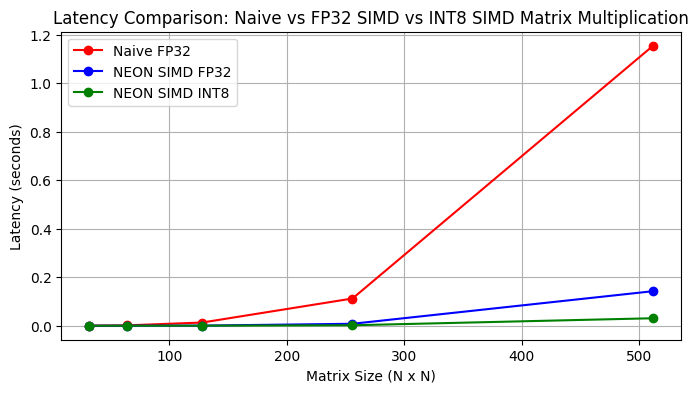

In [39]:
import matplotlib.pyplot as plt
import pandas as pd


# Load data from CSV files
naive_data = pd.read_csv('results/naive_latency_results.csv')
fp32_neon_data = pd.read_csv('results/fp32_neon_latency_results.csv')
int8_neon_data = pd.read_csv('results/int8_neon_latency_results.csv')

# Extract sizes and times
sizes = naive_data['Matrix Size']
naive_times = naive_data['Latency (seconds)']
fp32_neon_times = fp32_neon_data['Latency (seconds)']
int8_neon_times = int8_neon_data['Latency (seconds)']

plt.figure(figsize=(8, 4))

# Plotting the latency for each approach
plt.plot(sizes, naive_times, marker='o', linestyle='-', color='r', label='Naive FP32')
plt.plot(sizes, fp32_neon_times, marker='o', linestyle='-', color='b', label='NEON SIMD FP32')
plt.plot(sizes, int8_neon_times, marker='o', linestyle='-', color='g', label='NEON SIMD INT8')

# Adding labels and title
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Latency (seconds)')
plt.title('Latency Comparison: Naive vs FP32 SIMD vs INT8 SIMD Matrix Multiplication')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

As shown in the graph, the naive approach, which processes each matrix element individually, is the slowest. The SIMD floating-point implementation offers significant speedup, but the SIMD integer implementation is the fastest. This highlights the advantage of using lower-precision operations in AI network forward passes for improved performance.

# **Pytorch**
Having explored how ARM's SIMD capabilities in C can accelerate AI workloads, we now transition to PyTorch which is a versatile, high-level framework that balances flexibility and ease of use. PyTorch streamlines AI model development by abstracting low-level operations, enabling developers to focus on model architecture and experimentation rather than intricate implementation details.

Unlike the manual coding required for SIMD operations in C, PyTorch offers built-in support for tensor computations and hardware acceleration. It automatically utilizes processor optimizations, including SIMD and ARM's NEON instructions, to enhance performance without requiring developers to write low-level code.

In the next section, we benchmark Python-based matrix multiplication in both `int8` and `fp32` precision to validate that ARM's NEON instructions are being utilized for acceleration and performance. Building on this foundation, we will implement and optimize the inference of a state-of-the-art small language model, **Llama 3.2-1B**, showcasing PyTorch's capabilities for advanced AI workloads.

Let's start by checking the build configuration of our installed pytorch package. 

In [40]:
import torch
print(torch.__config__.show())

PyTorch built with:
  - GCC 10.2
  - C++ Version: 201703
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: NO AVX
  - Build settings: BLAS_INFO=open, BUILD_TYPE=Release, CXX_COMPILER=/opt/rh/devtoolset-10/root/usr/bin/c++, CXX_FLAGS=-ffunction-sections -fdata-sections -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-version=11 -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DLIBKINETO_NOXPUPTI=ON -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -O2 -fPIC -Wall -Wextra -Werror=return-type -Werror=non-virtual-dtor -Werror=bool-operation -Wnarrowing -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-unused-parameter -Wno-strict-overflow -Wno-strict-aliasing -Wno-stringop-overflow -Wsuggest-override -Wno-psabi -Wno-err

In this output you should see be able to see some flags such as: 
 - **USE_OPEN_MP=True** This library is used for parallelizing matrix multiplications across processing cores for acceleration.
 - **USE_NNPACK=ON** This is a low level library of operators that can use vectorized instructions on arm for accelerating operators.
 - **USE_MKLDNN=ON** This is a low level library primarily for x86 processors however contains vectorized implementation of operators for the AArch64 architecture, such as the raspberry pi 5. 

### **Investigation**
Lets start by checking out what pytorch is doing under the hood and make sure it is utilizing ARM's vector processing capabilities. 

To do so we will write two very simple scripts to perform a matrix multiply as we did earlier in c using floatin point 32 and integer 8 precisions. As you can see below, torch already implements these operations for you and abstracts alot of the complexity. 

In [41]:
%%writefile src/python/fp_matmul.py

import torch
a = torch.randn(1024, 1024, dtype=torch.float32, requires_grad=False)
b = torch.randn(1024, 1024, dtype=torch.float32, requires_grad=False)
c = torch.mm(a, b)


Overwriting src/python/fp_matmul.py


In [42]:
%%writefile src/python/int8_matmul.py
import torch

# Generate random int8 tensors
a = torch.randint(-128, 128, size=(1024, 1024), dtype=torch.int8)
b = torch.randint(-128, 128, size=(1024, 1024), dtype=torch.int8)
c = torch.mm(a, b)

Overwriting src/python/int8_matmul.py


**Using perf to check the assembly** The below code cells use perf to extract the assembly code required to run the above python scripts. We will use it to write out this assembly to a text file that can be analyzed. In doing so we can check wether the low-level libaries the torch.mm relies on for matrix multiplication are harnessing ARM's vector processing capabilities.  

***Note*** in the following code cells we are using a 10s timeout as we only need a sample of the assembly. The below code boxes will therefore take up to 10s each. 

In [43]:
import signal

def handler(signum, frame):
    raise TimeoutError("Execution timed out!")

signal.signal(signal.SIGALRM, handler)
signal.alarm(10)  # Set the alarm for 60 seconds

try:
    # Your long-running code here
    !rm -rf *perf*
    !rm -rf fp_matmul.txt
    !sudo perf record -e instructions:u -g $(which python) src/python/fp_matmul.py
    !sudo perf annotate > results/fp_matmul_instructions.txt
except TimeoutError as e:
    !rm -rf *perf*
    print("Completed")
finally:
    signal.alarm(0)  # Disable the alarm

[ perf record: Woken up 19 times to write data ]
[ perf record: Captured and wrote 4.687 MB perf.data (10564 samples) ]
Completed


In [44]:
import signal

def handler(signum, frame):
    raise TimeoutError("Execution timed out!")

signal.signal(signal.SIGALRM, handler)
signal.alarm(10)  # Set the alarm for 60 seconds

try:
    # Your long-running code here
    !rm -rf *perf*
    !rm -rf int8_matmul.txt
    !sudo perf record -e instructions:u -g $(which python) src/python/int8_matmul.py
    !sudo perf annotate > results/int8_matmul_instructions.txt
except TimeoutError as e:
    !rm -rf *perf*
    print("Completed")
finally:
    signal.alarm(0)  # Disable the alarm

[ perf record: Woken up 18 times to write data ]
[ perf record: Captured and wrote 4.352 MB perf.data (9882 samples) ]
Completed


- Now lets have a look inside. First for the float32 matrix multiply script. 

In [45]:
!grep -E 'fmul|fmla' results/fp_matmul_instructions.txt | head -n 20

    0.00 :   103738: fmul    d0, d0, d1
    0.00 :   2af658: fmul    v16.4s, v0.4s, v8.s[0]
    0.00 :   2af65c: fmul    v20.4s, v0.4s, v9.s[0]
    0.00 :   2af664: fmul    v24.4s, v0.4s, v10.s[0]
    0.00 :   2af668: fmul    v28.4s, v0.4s, v11.s[0]
    0.00 :   2af670: fmul    v17.4s, v1.4s, v8.s[0]
    0.00 :   2af674: fmul    v21.4s, v1.4s, v9.s[0]
    0.26 :   2af67c: fmul    v25.4s, v1.4s, v10.s[0]
    0.00 :   2af680: fmul    v29.4s, v1.4s, v11.s[0]
    0.00 :   2af688: fmul    v18.4s, v2.4s, v8.s[0]
    0.00 :   2af68c: fmul    v22.4s, v2.4s, v9.s[0]
    0.00 :   2af694: fmul    v19.4s, v3.4s, v8.s[0]
    0.00 :   2af698: fmul    v23.4s, v3.4s, v9.s[0]
    0.00 :   2af6a0: fmul    v26.4s, v2.4s, v10.s[0]
    0.00 :   2af6a4: fmul    v30.4s, v2.4s, v11.s[0]
    0.00 :   2af6ac: fmul    v27.4s, v3.4s, v10.s[0]
    0.00 :   2af6b0: fmul    v31.4s, v3.4s, v11.s[0]
    0.00 :   2af6b8: fmla    v16.4s, v4.4s, v12.s[0]
    0.00 :   2af6bc: fmla    v17.4s, v5.4s, v12.s[0]
    0.00 :   2

You should see printed out above some assembly instructions that the ARM processor will run. the structure of each line written out by `perf annotate` has the following format

***timestamp :    instruction_address: operation:   destination_registor, source_register, source operand***

The printout above should `fmul` and `fmla` instructions. Their definition is 

#### **Operation Definitions**
- **`fmul`**: Performs a floating-point multiplication operation between two operands.
- **`fmla`**: Performs a floating-point fused multiply-add operation, where the result of the multiplication is added to an accumulator in a single instruction.

**Understanding SIMD Processing**
The operands for these instructions are shown in the columns following the instruction, they are the destination_registor and the source_registor. The address of the operands determines whether the operation is scalar (e.g. works on a single element) or utilizes SIMD (Single Instruction, Multiple Data) processing:

- **Vector Registers**: Operands starting with a `v` (e.g., `v16.4s`, `v0.4s`, `v8.s[0]`) indicate that vector registers are being used. These registers contain multiple data lanes, enabling the instruction to process multiple elements simultaneously, thereby increasing throughput.
  - Example: `fmla v16.4s, v0.4s, v8.s[0]` performs the fused multiply-add operation on four single-precision floating-point elements in parallel (one for each lane of the vector register `v16`).

- **Scalar Registers**: Operands such as `s0`, `s1`, or `d0` refer to scalar registers that hold a single floating-point value. In this case, the operation is not vectorized and processes only one value at a time.
  - Example: `fmul s0, s1, s2` multiplies two single-precision floating-point values stored in `s1` and `s2` and writes the result to `s0`.

By examining the register types (vector vs. scalar), it becomes clear whether the instruction leverages SIMD for parallel processing or operates in a scalar manner and therefore whether torch is uses ARM's NEON SIMD processing capabilities to accelerate the matrix muliply operation. 

***Note*** Should no vector registers show up in your instruction list above, please look inside the file results/fp_matmul_instructions.txt to identify any vector register utilization. 


In [46]:
!grep -E 'mla|dup|addv|umov' results/int8_matmul_instructions.txt | head -n 20

    0.00 :   3740150:        dup     v2.16b, w0
    0.00 :   3740160:        mla     v0.16b, v1.16b, v2.16b
    0.00 :   3740194:        dup     v1.8b, w0
    0.00 :   37401a8:        mla     v0.8b, v2.8b, v1.8b
    0.00 :   374053c:        mla     v0.16b, v2.16b, v1.16b
    0.00 :   3740548:        addv    b0, v0.16b
    0.00 :   3740554:        umov    w5, v0.b[0]
    0.00 :   3740598:        addv    b0, v0.8b
    0.00 :   374059c:        umov    w12, v0.b[0]
    0.00 :   374082c:        dup     v2.16b, w0
    0.00 :   3740840:        mla     v0.16b, v1.16b, v2.16b
    0.00 :   3740878:        dup     v1.8b, w0
    0.00 :   374088c:        mla     v0.8b, v2.8b, v1.8b
    0.00 :   3740d58:        mla     v9.16b, v4.16b, v17.16b
    0.00 :   3740d5c:        mla     v21.16b, v2.16b, v18.16b
    0.00 :   3740d80:        mla     v22.16b, v1.16b, v19.16b
    0.00 :   3740d84:        mla     v3.16b, v0.16b, v20.16b
    0.00 :   3740d90:        addv    b3, v3.16b
    0.00 :   3740d98:       

#### **Instruction Definitions**
- **`dup`**: Duplicates the value of a scalar register (e.g., `w0`) into all lanes of a SIMD vector register (e.g., `v2.16b`). This allows the same value to be broadcast across multiple lanes for parallel processing.
- **`mla`**: Performs a fused multiply-accumulate operation. It multiplies corresponding elements from two SIMD vector registers and adds the results to the accumulator register. This operation is performed on all lanes in parallel.
- **`addv`**: Adds all elements in a SIMD vector register and stores the resulting sum in a scalar register. This is typically used for reduction operations to aggregate data from multiple lanes.
- **`umov`**: Extracts a specific lane from a SIMD vector register and moves it to a scalar register. This is useful for accessing individual elements after SIMD processing.

These instructions shown above indicate that torch is utilizing ARMS SIMD capabilities. 

***Note*** Should no vector registers show up in the instruction list above, please look inside the file results/fp_matmul_instructions.txt to identify any vector register utilization. 

## **Benchmarking Pytorch Linear Layer**
Now we have shown that pytorch is utilizing the vector processing capability of ARM by defualt, we can benchmark it's operations and see the performance increase from floating point to integer. 

In [47]:
import time 
import numpy as np
torch.set_num_threads(1)

def benchmark(inputs, func, num_runs=10): 
    times = []
    for _ in range(3): 
        func(inputs)

    for _ in range(num_runs): 
        st = time.time()
        func(inputs)
        times.append(time.time() - st)

    return np.mean(times)

In [48]:
import torch 
sizes = [32, 64, 128, 256, 512, 1024]

In [49]:
import torch 
import torch.nn as nn

float_times = []
for size in sizes:
    # floating point measurements 
    x = torch.randn(size, size, dtype=torch.float32, requires_grad=False)
    linear = nn.Linear(size, size)
    float_times.append(benchmark(x, linear))

In [50]:
torch.backends.quantized.engine = 'qnnpack'
!python --version
print(f"torch version: ", torch.__version__)
print(f"Quantized backedn: ", torch.backends.quantized.engine)

Python 3.12.0
torch version:  2.5.1
Quantized backedn:  qnnpack


now int8 measurements 

In [51]:
import torch 
import torch.nn.quantized as nnq

int8_times = []
for size in sizes:
    # floating point measurements 
    x = torch.randn(size, size, dtype=torch.float32, requires_grad=False)
    x_quant = torch.quantize_per_tensor(x, scale=x.abs().max()/127, zero_point=0, dtype=torch.qint8)
    qlinear = nnq.Linear(size, size, dtype=torch.qint8)
    qlinear.set_weight_bias(x_quant, None)
    int8_times.append(benchmark(x_quant, qlinear))

plot the results

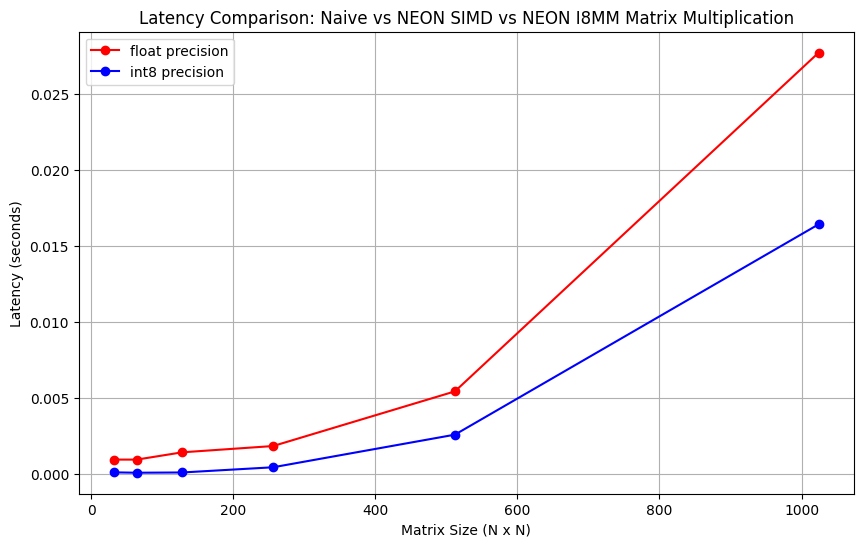

In [52]:
import matplotlib.pyplot as plt
import pandas as pd




plt.figure(figsize=(10, 6))

# Plotting the latency for each approach
plt.plot(sizes, float_times, marker='o', linestyle='-', color='r', label='float precision')
plt.plot(sizes, int8_times, marker='o', linestyle='-', color='b', label='int8 precision')
# Adding labels and title
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Latency (seconds)')
plt.title('Latency Comparison: Naive vs NEON SIMD vs NEON I8MM Matrix Multiplication')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


# **Lamma3.2-1B**

In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM


tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")

/home/oeg1n18/github/Generative_AI_on_arm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-3.2-1B.
401 Client Error. (Request ID: Root=1-6745b40b-66a751db26e6f0610c0487fa;14799d29-367c-4a1d-8e50-fae74b4c39e1)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-3.2-1B/resolve/main/config.json.
Access to model meta-llama/Llama-3.2-1B is restricted. You must have access to it and be authenticated to access it. Please log in.

In [ ]:
prompt = "ARM is a company that designs" 
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_length=50)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

In [ ]:
model

Custom Quantization

In [ ]:
import torch
import math
import torch.nn as nn

class WeightOnlyInt8Linear(nn.Module): 
    def __init__(self, in_features, out_features, bias=True): 
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features 
        self.scale = nn.Parameter(torch.ones(1), requires_grad=False)
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias: 
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else: 
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def setup(self, fp_weight): 
        quantized, scale = self.quantize(fp_weight)
        self.weight.data = quantized 
        self.scale.data = scale

    def quantize(self, tensor):
        qmin = -(2 ** 31)
        qmax = 2 ** 31 - 1
        absmax = tensor.abs().max()
        
        # Avoid division by zero by adding a small epsilon
        eps = 1e-8
        scale = torch.tensor((absmax / qmax).clamp(min=eps))
        
        quantized = torch.round(tensor / scale).clamp(qmin, qmax)
        return quantized, scale

    def forward(self, x):
        # Dequantize the weights
        dequantized_weight = self.weight * self.scale
        
        # Perform the matrix multiplication
        output = torch.matmul(x, dequantized_weight.t())
        
        # Add the bias if it exists
        if self.bias is not None:
            output += self.bias
            
        # Avoid inf values by clamping the output (if needed)
        output = output.clamp(-1e4, 1e4)  # Example clamping, adjust based on your requirements
        
        return output


In [ ]:
def quantize_model(model): 
    for name, module in list(model.named_modules()): 
        if isinstance(module, nn.Linear): 
            module = WeightOnlyInt8Linear(module.in_features, module.out_features)
            module.setup(module.weight.data)
            setattr(model, name, module)
    return model

model = quantize_model(model)

In [ ]:
model

In [ ]:
prompt = "ARM is a company that designs" 
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_length=50)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)